# 2. How to Build a Model

`Model` is composed of a set of `Species` and `ReactionRule`s.

* `Species` describes a molecule entitie (e.g. a type or state of a protein) in the model. `Species` also has its attributes like the size.  
* `ReactionRule` describes the interactions between `Species` (e.g. binding and unbinding).

In [1]:
%matplotlib inline
from ecell4.prelude import *

## 2.1. Species

`Species` can be generated by giving its name:

In [2]:
sp1 = Species("A")
print(sp1.serial())

A


There are some naming conventions for the name of `Species`.
This naming convention requires careful use of special symbols (e.g. parenthesis `()`, dot `.`, underbar `_`), numbers and blank.

`Species` has a set of APIs for handling its attributes:

In [3]:
sp1.set_attribute("radius", 0.005)
sp1.set_attribute("D", 1)
sp1.set_attribute("location", "cytoplasm")
print(sp1.has_attribute("radius"))
print(sp1.get_attribute("radius"))
print(sp1.get_attribute("radius").magnitude)
print(sp1.get_attribute("radius").units)
print(sp1.has_attribute("location"))
print(sp1.get_attribute("location"))
sp1.remove_attribute("radius")
print(sp1.has_attribute("radius"))

True
0.005

True
cytoplasm
False


The arguments in `set_attribute` is the name of attribute and its value. The name of an attribute is given as a string, and its value is a string, integer, float, or boolean. `get_attribute` returns the value set. For an integer or float attribute, `get_attribute` returns a quantity object, which is a pair of value (`magnitude`) and unit (`units`).

There is a shortcut to set the attributes above at once because `radius`, `D` (a diffusion coefficient) and `location` are frequently used.

In [4]:
sp1 = Species("A", 0.005, 1, "cytoplasm")  # serial, radius, D, location

The equality between `Species` is just evaluated based on their `serial`:

In [5]:
print(Species("A") == Species("B"))
print(Species("A") == Species("A"))

False
True


A Species consists of one or more UnitSpecies:

In [6]:
sp1 = Species()
usp1 = UnitSpecies("C")
print(usp1.serial())
sp1.add_unit(usp1)
sp1.add_unit(UnitSpecies("A"))
sp1.add_unit(UnitSpecies("B"))
print(sp1.serial(), len(sp1.units()))

C
C.A.B 3


A `Species` can be reproduced from its `serial`. In the `serial`, all `UnitSpecies` are joined with the separator, dot `.`. The order of `UnitSpecies` affects the `Species` comparison.

In [7]:
sp1 = Species("C.A.B")
print(sp1.serial())
print(Species("A.B.C") == Species("C.A.B"))
print(Species("A.B.C") == Species("A.B.C"))

C.A.B
False
True


`UnitSpecies` can have sites. Sites consists of a `name`, `state` and `bond`, and are sorted automatically in `UnitSpecies`. `name` must be unique in a `UnitSpecies`. All the value have to be string. Do not include parenthesis, dot and blank, and not start from numbers except for `bond`.

In [8]:
usp1 = UnitSpecies("A")
usp1.add_site("us", "u", "")
usp1.add_site("ps", "p", "_")
usp1.add_site("bs", "", "_")
print(usp1.serial())

A(bs^_,ps=p^_,us=u)


`UnitSpecies` can be also reproduced from its serial. Please be careful with the order of sites where a site with a state must be placed after sites with no state specification:

In [9]:
usp1 = UnitSpecies()
usp1.deserialize("A(bs^_, us=u, ps=p^_)")
print(usp1.serial())

A(bs^_,ps=p^_,us=u)


Of course, a site of `UnitSpecies` is available even in `Species`' serial.

In [10]:
sp1 = Species("A(bs^1, ps=u).A(bs, ps=p^1)")
print(sp1.serial())
print(len(sp1.units()))

A(bs^1, ps=u).A(bs, ps=p^1)
2


The information (`UnitSpecies` and its `site`) is used for rule-based modeling. The way of rule-based modeling in E-Cell4 is explained in [7. Introduction of Rule-based Modeling](tutorial7.html).

## 2.2. ReactionRule

`ReactionRule` consists of `reactants`, `products` and `k`. `reactants` and `products` are a list of `Species`, and `k` is a kinetic rate given as a floating number.

In [11]:
rr1 = ReactionRule()
rr1.add_reactant(Species("A"))
rr1.add_reactant(Species("B"))
rr1.add_product(Species("C"))
rr1.set_k(1.0)

Here is a binding reaction from `A` and `B` to `C`. In this reaction definition, you don't need to set attributes to `Species`. The above series of operations can be written in one line using `create_binding_reaction_rule(Species("A"), Species("B"), Species("C"), 1.0)`.

You can use `as_string` function to check `ReactionRule`:

In [12]:
rr1 = create_binding_reaction_rule(Species("A"), Species("B"), Species("C"), 1.0)
print(rr1.as_string())

A+B>C|1


You can also provide components to the constructor:

In [13]:
rr1 = ReactionRule([Species("A"), Species("B")], [Species("C")], 1.0)
print(rr1.as_string())

A+B>C|1


Basically `ReactionRule` represents a mass action reaction with the rate `k`. `ode` solver also supports rate laws thought it's under development yet. `ode.ODERatelaw` is explained in **6. How to Solve ODEs with Rate Law Functions** [local ipynb](tutorial6.ipynb) [readthedocs](http://ecell4.readthedocs.io/en/latest/tutorials/tutorial6.html).

## 2.3. NetworkModel

You have learned how to create some `Model` components. Next let's put the components in a `Model`.

In [14]:
sp1 = Species("A", 0.005, 1)
sp2 = Species("B", 0.005, 1)
sp3 = Species("C", 0.01, 0.5)

In [15]:
rr1 = create_binding_reaction_rule(Species("A"), Species("B"), Species("C"), 0.01)
rr2 = create_unbinding_reaction_rule(Species("C"), Species("A"), Species("B"), 0.3)

You can put the `Species` and `ReactionRule` with `add_species_attribute` and `add_reaction_rule`.

In [16]:
m1 = NetworkModel()
m1.add_species_attribute(sp1)
m1.add_species_attribute(sp2)
m1.add_species_attribute(sp3)
m1.add_reaction_rule(rr1)
m1.add_reaction_rule(rr2)

Now we have a simple model with the binding and unbinding reactions. You can use `species_attributes` and `reaction_rules` to check the `Model`.

In [17]:
print([sp.serial() for sp in m1.species_attributes()])
print([rr.as_string() for rr in m1.reaction_rules()])

['A', 'B', 'C']
['A+B>C|0.01', 'C>A+B|0.3']


The `Species` attributes are required for the spatial `Model`, but not required for the nonspatial `Model` (i.e. `gillespie` or `ode`). The attribute pushed first has higher priority than one pushed later. You can also attribute a `Species` based on the attributes in a `Model`.

In [18]:
sp1 = Species("A")
print(sp1.has_attribute("radius"))
sp2 = m1.apply_species_attributes(sp1)
print(sp2.has_attribute("radius"))
print(sp2.get_attribute("radius").magnitude)

False
True
0.005


For your information, all functions related to `Species`, `ReactionRule` and `NetworkModel` above are also available on C++ in the same way.

Finally, you can solve this model with `run_simulation` as explained in [1. Brief Tour of E-Cell4 Simulations](tutorial1.html) :

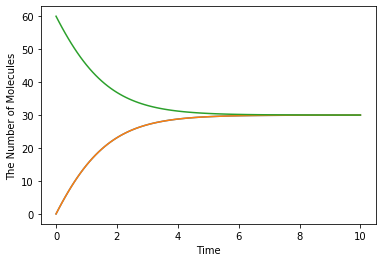

In [19]:
run_simulation(10.0, model=m1, y0={'C': 60})

## 2.4. Python Utilities to Build a Model

As shown in [1. Brief Tour of E-Cell4 Simulations](tutorial1.html), E-Cell4 also provides the easier way to build a model using `with` statement:

In [20]:
with species_attributes():
    A | B | {'radius': 0.005, 'D': 1}
    C | {'radius': 0.01, 'D': 0.5}

with reaction_rules():
    A + B == C | (0.01, 0.3)

m1 = get_model()

For reversible reactions, `==` is available. In the `with` statement, undeclared variables are automaticaly assumed to be a `Species`. Any Python variables, functions and statement are available even in the `with` block.

In [21]:
from math import log

ka, kd, kf = 0.01, 0.3, 0.1
tau = 10.0

with reaction_rules():
    E0 + S == ES | (ka, kd)

    if tau > 0:
        ES > E1 + P | kf
        E1 > E0 | log(2) / tau
    else:
        ES > E0 + P | kf

m1 = get_model()
del ka, kd, kf, tau

Meanwhile, once some variable is declared even outside the block, you can not use its name as a `Species` as follows:

In [22]:
A = 10

try:
    with reaction_rules():
        A + B == C | (0.01, 0.3)
except Exception as e:
    print(repr(e))

del A

TypeError("Argument 1 must be AnyCallable, ParseObj, InvExp or MulExp. 'int' was given [10].")


This is because `A + B == C` is evaluated as `10 + B == C` due to `A = 10`.

In the absence of left or right hand side of `ReactionRule` like synthesis or degradation, you may want to describe like:


```python
with reaction_rules():
    A > | 1.0  # XXX: will raise SyntaxError
    > A | 1.0  # XXX: will raise SyntaxError
```

However, this is not accepted because of the syntax rule on Python. To describe this case, a special operator, tilde `~`, is available. `~` sets a stoichiometric coefficient of the following `Species` as zero, which means the `Species` is just ignored in the `ReactionRule`.

In [23]:
with reaction_rules():
    ~A > A | 2.0  # equivalent to `create_synthesis_reaction_rule`
    A > ~A | 1.0  # equivalent to `create_degradation_reaction_rule`

m1 = get_model()
print([rr.as_string() for rr in m1.reaction_rules()])

['>A|2', 'A>|1']


The following `Species`' name is not necessarily needed to be the same as others. The model above describes $[A]'=2-1\times[A]$:

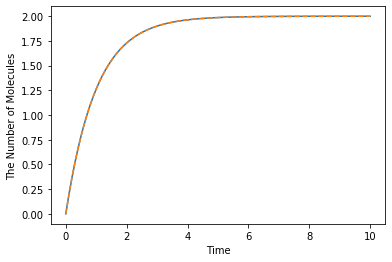

In [24]:
from math import exp
ret = run_simulation(10.0, model=m1)
ret.plot('-', lambda t: 2.0 * (1 - exp(-t)), '--')

A chain of reactions can be described in one line. To split a line into two or more physical lines, wrap lines in a parenthesis:

In [25]:
with reaction_rules():
    (E + S == ES | (0.5, 1.0)
         > E + P | 1.5)

m1 = get_model()
print([rr.as_string() for rr in m1.reaction_rules()])

['E+S>ES|0.5', 'ES>E+S|1', 'ES>E+P|1.5']


The method uses global variables in `ecell4.util.decorator` (e.g. `REACTION_RULES`) to cache objects created in the `with` statement:

In [26]:
import ecell4.util.decorator

with reaction_rules():
    A + B == C | (0.01, 0.3)

print(ecell4.util.decorator.REACTION_RULES)  #XXX: Only for debugging
get_model()
print(ecell4.util.decorator.REACTION_RULES)  #XXX: Only for debugging

[<ecell4_base.core.ReactionRule object at 0x149ce5bad378>, <ecell4_base.core.ReactionRule object at 0x149ce5bad1f0>]
[]


Python decorator functions are also available. Decorator functions improve the modularity of the `Model`. 

In [27]:
@species_attributes
def attrgen1(radius, D):
    A | B | {'radius': radius, 'D': D}
    C | {'radius': radius * 2, 'D': D * 0.5}

@reaction_rules
def rrgen1(kon, koff):
    A + B == C | (kon, koff)

attrs1 = attrgen1(0.005, 1)
rrs1 = rrgen1(0.01, 0.3)
print(attrs1)
print(rrs1)

[(<ecell4_base.core.Species object at 0x149ce5c1b1b8>, False), (<ecell4_base.core.Species object at 0x149ce5c1b570>, False), (<ecell4_base.core.Species object at 0x149ce5c1b768>, False)]
[<ecell4_base.core.ReactionRule object at 0x149ce5c1bb58>, <ecell4_base.core.ReactionRule object at 0x149ce5c1b260>]


In contrast to the `with` statement, do **not** add parentheses after the decorator here. The functions decorated by `reaction_rules` and `species_attributes` return a list of `ReactionRule`s and `Species` respectively. The list can be registered to `Model` at once by using `add_reaction_rules` and `add_species_attributes`. 

In [28]:
m1 = NetworkModel()
m1.add_species_attributes(attrs1)
m1.add_reaction_rules(rrs1)
print(m1.num_reaction_rules())

2


This method is modular and reusable relative to the way using `with` statement.

The functions decorated by `species_attributes` and `reaction_rules` are also reusable in the `with` statement.

In [29]:
@reaction_rules
def michaelis_menten(S, P, E, ES, kf, kr, kcat):
    S + E == ES | (kf, kr)
    ES > P + E | kcat

with reaction_rules():
    michaelis_menten(K, Kp, KK, KK_K, 0.01, 0.3, 0.15)
    michaelis_menten(Kp, K, PP, PP_Kp, 0.01, 0.3, 0.15)

m1 = get_model()
show(m1)


K + KK > KK_K | 0.01
KK_K > K + KK | 0.3
KK_K > Kp + KK | 0.15
Kp + PP > PP_Kp | 0.01
PP_Kp > Kp + PP | 0.3
PP_Kp > K + PP | 0.15
